# 1-0. Import

In [189]:
import os.path as osp
import openslide
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from skimage.filters import threshold_otsu

from openslide.deepzoom import DeepZoomGenerator

import cv2
from keras.utils.np_utils import to_categorical

# network

from keras.models import Sequential
from keras.layers import Lambda, Dropout
from keras.layers.convolutional import Convolution2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D

# train

from sklearn.model_selection import StratifiedShuffleSplit
from datetime import datetime

# evaluate

import matplotlib.gridspec as gridspec
from sklearn.metrics import confusion_matrix
from tqdm import tqdm

import math
from PIL import Image
from xml.etree.ElementTree import ElementTree, Element, SubElement
from io import BytesIO

# 1-1. Data Load

In [2]:
slide_path = 'data/train/image/positive/Slide001.mrxs'
slide = openslide.open_slide(slide_path)

BASE_TRUTH_DIR = Path('data/train/mask')
truth_path = str(BASE_TRUTH_DIR/'positive/Slide001.png')
truth = openslide.open_slide(truth_path)

print("original slide dimensions %dx%d" % slide.dimensions)
print("original truth dimensions %dx%d" % truth.dimensions)

original slide dimensions 93970x234042
original truth dimensions 5316x10007


# 1-2. Fit Data Shape

- 밑에 a, b 괄호친 부분은 csv 파일 읽고 min_x, min_y 넣어야함 (이게 사실 필요가 없음)

- https://openslide.org/api/python/#module-openslide

- 이부분은 opensilde_test.ipynb 파일에 실험한 것 참고


## Check if works

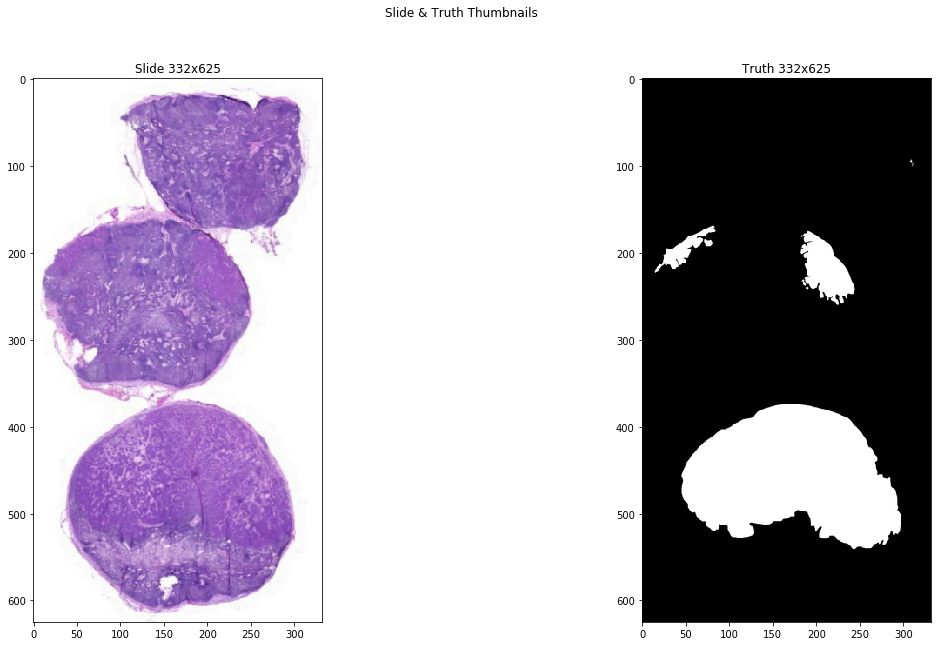

In [10]:

# f, axes = plt.subplots(1, 2, figsize=(20, 10));
# ax = axes.ravel()
# ax[0].imshow(slide4);
# ax[0].set_title('Slide %dx%d' % slide4.size)
# ax[1].imshow(thumbnail_truth.convert('L'), cmap='gray');
# ax[1].set_title('Truth %dx%d' % thumbnail_truth.size)
# f.suptitle('Slide & Truth Thumbnails ');

# 1-3 Patch Gen

- get_thumbnail(size)
: Return an Image containing an RGB thumbnail of the slide.
- patch size 만큼 dimensions 나누기. 1 픽셀이 하나의 패치가 됨 -> DeepZoomGenerator로 다시 확대가능 (patch_size만큼) (2의 거듭제곱으로)
- tissue 검사 - patch['is_tissue'] : ostu method
- tumor 검사 - patch['is_tummor'] 라벨 : mask로 구분
- 경로 추가 저장 = patch['slide_path']
- 최종 training set = concat[patch, patch_y]

In [186]:
PATCH_SIZE = 256
IS_TRAIN = True

In [284]:
def find_patches_from_slide(slide_path, base_truth_dir=BASE_TRUTH_DIR,patch_size=PATCH_SIZE,filter_non_tissue=True):
    """Returns a dataframe of all patches in slide
    input: slide_path: path to WSI file
    output: samples: dataframe with the following columns:
        slide_path: path of slide
        is_tissue: sample contains tissue
        is_tumor: truth status of sample
        tile_loc: coordinates of samples in slide
        
    
    option: base_truth_dir: directory of truth slides
    option: filter_non_tissue: Remove samples no tissue detected
    option: patch_size: patch_size
    slide_contains_tumor true -> taking the label from mask png
    """
    slide_contains_tumor = 'pos' in slide_path
    slide = openslide.open_slide(slide_path)

    truth_path = str(BASE_TRUTH_DIR/'positive/Slide001.png') # 이부분도 slide에서 불러들여서 자동으로 읽는걸로 바꾸고
    truth = openslide.open_slide(truth_path)
    
    ############### read_region을 위한 start, level, size를 구함 #######################
    start = (int(slide.properties.get('openslide.bounds-x',0)),int(slide.properties.get('openslide.bounds-y',0))) # BOUNDS_OFFSET_PROPS
    
    level = np.log2(patch_size) # 되도록 레벨은 2의 거듭제곱으로 설정하자
    level = int(level)
    
    ####### 다음은 mask.png file 맞추기 위해  mask downsample size와 똑같은 size를 구함
    BOUNDS_OFFSET_PROPS = (openslide.PROPERTY_NAME_BOUNDS_X,
                openslide.PROPERTY_NAME_BOUNDS_Y)
    BOUNDS_SIZE_PROPS = (openslide.PROPERTY_NAME_BOUNDS_WIDTH,
                    openslide.PROPERTY_NAME_BOUNDS_HEIGHT)

    size_scale = tuple(int(slide.properties.get(prop, l0_lim)) / l0_lim
                        for prop, l0_lim in zip(BOUNDS_SIZE_PROPS,
                        slide.dimensions))
    
    _l_dimensions = tuple(tuple(int(math.ceil(l_lim * scale))
                        for l_lim, scale in zip(l_size, size_scale))
                        for l_size in slide.level_dimensions)
    size = _l_dimensions[level]
    
    ####################################################################################
    
    # is_tissue 부분
    with openslide.open_slide(slide_path) as slide:
        slide4 = slide.read_region(start,level,size) # 3초 #read_region(location, level, size)
    slide4_grey = np.array(slide4.convert('L'))
    binary = slide4_grey > 0  # black이면 0임
    
    # 검은색 제외하고 흰색영역에 대해서도 작업해주어야함.
    slide4_not_black = slide4_grey[slide4_grey>0]
    thresh = threshold_otsu(slide4_not_black)
    
    I, J = slide4_grey.shape
    for i in range(I):
        for j in range(J):
            if slide4_grey[i,j] > thresh :
                binary[i,j] = False
    patches = pd.DataFrame(pd.DataFrame(binary).stack())
    patches['is_tissue'] = patches[0]
    patches.drop(0, axis=1,inplace =True)
    patches['slide_path'] = slide_path

    #print('# tissues in patches : ',len(patches[patches.is_tissue>0]))    
    
    # is_tumor 부분
    if slide_contains_tumor:
        thumbnail_truth = truth.get_thumbnail(size) 
        #print('type thumbnail_truth, ',type(thumbnail_truth))
        patches_y = pd.DataFrame(pd.DataFrame(np.array(thumbnail_truth.convert("L"))).stack())
        patches_y['is_tumor'] = patches_y[0] > 0
        patches_y['is_all_tumor'] = patches_y[0] == 255
        
        patches_y.drop(0, axis=1, inplace=True)
        samples = pd.concat([patches, patches_y], axis=1) #len(samples)
    else:
        samples = patches
        samples['is_tumor'] = False
    
    if filter_non_tissue:
        samples = samples[samples.is_tissue == True] # remove patches with no tissue #samples = samples[samples.is_tissue == True]
    
    filter_only_all_tumor = True
        
    samples['tile_loc'] = list(samples.index)
    all_tissue_samples1 = samples[samples.is_tumor==False]
    all_tissue_samples1 = all_tissue_samples1.append(samples[samples.is_all_tumor==True])
    
    all_tissue_samples1.reset_index(inplace=True, drop=True)
    
    return all_tissue_samples1

In [201]:
all_tissue_samples = find_patches_from_slide(slide_path)
print('Total patches in slide: %d' % len(all_tissue_samples)) 
all_tissue_samples.iloc[:10]
all_tissue_samples.is_tumor.value_counts() 

Total patches in slide: 109345


False    74490
True     34855
Name: is_tumor, dtype: int64

In [205]:
# len(all_tissue_samples[all_tissue_samples.is_tumor==False]) # 74490
# len(all_tissue_samples[all_tissue_samples.is_all_tumor==True]) # 30723
# all_tissue_samples1 = all_tissue_samples[all_tissue_samples.is_tumor==False]
# all_tissue_samples1 = all_tissue_samples1.append(all_tissue_samples[all_tissue_samples.is_all_tumor==True])
# all_tissue_samples1.is_tumor.value_counts() # 애매한 4천개 줄음
# '''
# False    74490
# True     30723
# Name: is_tumor, dtype: int64
# '''

74490

# check the is_tissue part

- 원래 이미지를 convert하면 흰색(배경)이미지는 255로 높은 값을 가지게 됨
- otsu라는 method를 통해서 threshold(이 이상부터는 배경값이라고 여길 수 있는)를 얻고
- 이 threshold(아래 변수에서는 thresh)보다 크면 배경, 아니면 배경 아님
- 그런데 slide에서 slide4를 convert하면 대부분의 배경색이 자체적으로 검은색으로 칠해진것을 확인할 수 있었음
- 따라서 다음과 같이 is_tissue를 판별해줌
    - 1. 일단 grey로 convert후, 0보다 크면 True 아니면 False (검은색 부분 처리)
    - 2. black이 아닌 남은 값들로 otsu method를 통해 threshold 계산 후 배경부분 처리(흰색 부분 처리)

In [ ]:
# slide4
# slide4_grey = np.array(slide4.convert('L'))
# slide4.convert('L')
# slide4_grey.shape # (625, 332)
# thresh = threshold_otsu(slide4_grey)
# binary = slide4_grey > thresh
# binary.shape # (625, 332)
# slide4_not_black = slide4_grey[slide4_grey>0]
# thresh = threshold_otsu(slide4_not_black)
# thresh # 186
# type(slide4_grey)
# binary = slide4_grey > 0
# slide4_grey[0,0]

In [ ]:
# 아래 코드로 패치들중에 배경이 많이 들어간 것을 확인할 수 있었음
# from PIL import Image
# im = Image.fromarray(np.uint8(example_X[26]))
# thresh = threshold_otsu(np.array(im.convert('L')))
# print(thresh) # 6 : 251 10 ; 249 17 : 251 14: 154 23: 152, 24: 190, 25 : 182 28 : 249 30: 123 39 : 195 58 : 162 #180이상은 다시 tissue 아님
# np.max(example_X[1])
# im = Image.fromarray(np.uint8(example_X[6]))
# im.convert('L') # 원래는 이렇게 돼야 정상인데
# np.max(example_X[1])
# im = Image.fromarray(np.uint8(example_X[0]))
# thresh = threshold_otsu(np.array(im.convert('L')))
# binary = np.array(im.convert('L')) > thresh

## Check if works - slide_tile_loc, 

- tile(slide에서 뽑은 패치)와 tile_truth(mask_patch) 간의 매칭이 되지 않아 아래 작업 수행 알게된 사실은 다음 3가지
    - 1. tiles의 shape은 (256, 256) , tiles_truth의 shape은 (16,16) (하지만 truth는 이미 원본 최고레벨 슬라이드의 1/16이므로 이렇게 맞춰줘야 같은 영역을 매칭
    - 2. get_tile 할때는 x,y바꿔서 넣어줘야함
    - 3. tiles의 타일 사이즈 (368, 915) tiles_truth의 타일 사이즈 (333,626) 으로 위에서 thumbnail 얻었을 때보다 x,y가 1씩 큼 그래서 끝부분 확인
    - 4. slide의 타일과  바로 가져오려면 min_offset 고려해서 가져와야함. start / patch_size 만큼 더해줘야함 

In [157]:
# start #(7744, 39056)
# tiles = DeepZoomGenerator(slide,tile_size=256, overlap=0 ,limit_bounds = False)
# tiles_truth = DeepZoomGenerator(truth, tile_size=16, overlap = 0, limit_bounds = False)
# print('tile, truth level # : ',tiles.level_count,
# tiles_truth.level_count) # tile, truth level # :  19 15
# tiles.level_dimensions[18] # (93970, 234042)
# tiles.tile_count # 끝에 잘리는부분도 하나로 만듬 (각 영역이 추가됨)
# tiles_truth.level_tiles[14] # tiles.level_tiles[18]
# tiles.level_tiles[18] # (368, 915)
# tiles.level_dimensions[10] #(368, 915)
# tiles_truth.level_dimensions[10] # (333, 626)
# samples[samples.is_tumor>0].head(5)  # is_tumor > 0 확인
# thumbnail_truth.size # (332, 625) thumbnail_truth = truth.get_thumbnail((truth.dimensions[0] / truth_div, truth.dimensions[1] / truth_div))
# k = pd.DataFrame(pd.DataFrame(np.array(thumbnail_truth.convert("L"))).stack())
# k['tile_loc'] = list(k.index)
# k.reset_index(inplace=True, drop=True) # tile_loc 은 x,y가 거꾸로 들어감 (height, width) 정보라고 보면됨 (y,x)로 들어감
# k = k[k[0]>0]
# k


In [159]:
# visual 
# f, axes = plt.subplots(2, 2, figsize=(10, 5))
# axes[0, 0].imshow(tiles.get_tile(tiles.level_count-1, (339, 247))); # turth에서 x는 30만큼, y는 152만큼 더해줘야함
# axes[0, 0].set_title('Tumor Example');
# axes[0, 1].imshow(tiles_truth.get_tile(tiles_truth.level_count-1,(309,95)));
# axes[0, 1].set_title('Truth mask (white=tumor, black=not_tumor)')

# axes[1, 0].imshow(tiles.get_tile(tiles.level_count-1, (362, 777)));
# axes[1, 0].set_title('Tumor Example');
# axes[1, 1].imshow(tiles_truth.get_tile(tiles_truth.level_count-1,(332,625))); # turth 끝 경계
# axes[1, 1].set_title('Truth mask (white=tumor, black=not_tumor)')

# 1-4. Train data Gen

In [221]:
len(all_tissue_samples1)
range(len(all_tissue_samples1))
# https://pandas.pydata.org/pandas-docs/version/0.23.4/generated/pandas.Series.html
type(all_tissue_samples1.slide_path)
b = all_tissue_samples1.slide_path.unique()
all_tissue_samples1.iloc[0]

is_tissue                                          True
slide_path      data/train/image/positive/Slide001.mrxs
is_tumor                                          False
is_all_tumor                                      False
tile_loc                                      (17, 165)
Name: 0, dtype: object

In [228]:
NUM_CLASSES = 2 # not_tumor, tumor

def gen_imgs(samples, batch_size,patch_size = PATCH_SIZE, base_truth_dir=BASE_TRUTH_DIR, shuffle=True):
    """This function returns a generator that 
    yields tuples of (
        X: tensor, float - [batch_size, patch_size, patch_size, 3]
        y: tensor, int32 - [batch_size, patch_size, patch_size, NUM_CLASSES]
    )
    
    
    input: samples: samples dataframe
    input: batch_size: The number of images to return for each pull
    output: yield (X_train, y_train): generator of X, y tensors
    
    option: base_truth_dir: path, directory of truth slides
    option: shuffle: bool, if True shuffle samples
    """
    
    num_samples = len(samples)
    while 1: # Loop forever so the generator never terminates
        if shuffle:
            samples = samples.sample(frac=1) # shuffle samples
        
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples.iloc[offset:offset+batch_size]
        
            images = []
            masks = []
            for _, batch_sample in batch_samples.iterrows(): # 배치마다 deep zoom 하네 약간 비효율적
                slide_contains_tumor = 'pos' in slide_path
                
                with openslide.open_slide(batch_sample.slide_path) as slide:
                     
                    tiles = DeepZoomGenerator(slide, tile_size=patch_size, overlap=0, limit_bounds=False)
                    
                    # 이부분도 꼼꼼하게 확인해봐야한다. 경계가 제대로 작업이 되지 않았을 수 있으니 
                    x, y = batch_sample.tile_loc[::-1]
                    
                    start_x = int(slide.properties.get('openslide.bounds-x',0))
                    start_y = int(slide.properties.get('openslide.bounds-y',0))
                    start_x = start_x / patch_size
                    start_y = start_y / patch_size
                    
                    x += start_x
                    y += start_y
                    img = tiles.get_tile(tiles.level_count-1, (x,y))
                
                mask_size_up = np.zeros((patch_size,patch_size))
                a,b=mask_size_up.shape
                # only load truth mask for tumor slides
                if slide_contains_tumor:
                    truth_path = str(base_truth_dir/'positive/Slide001.png')
                    with openslide.open_slide(truth_path) as truth:
                        truth_tiles = DeepZoomGenerator(truth, tile_size=16, overlap=0, limit_bounds=False)
                        mask = truth_tiles.get_tile(truth_tiles.level_count-1, batch_sample.tile_loc[::-1])
                        mask = (cv2.cvtColor(np.array(mask), cv2.COLOR_RGB2GRAY) > 0).astype(int)
                        
                        # mask_size_up , 16 to 256
                        
                        for i in range(a):
                            for j in range(b) :
                                k = i//16
                                l = j//16
                                mask_size_up[i,j] = mask[k,l]

                images.append(np.array(img))
                masks.append(mask_size_up)

            X_train = np.array(images)
            y_train = np.array(masks)
            print('x_train_shape :', X_train.shape)
            
            # 이부분도 patch size로 바꿔야함
            y_train = to_categorical(y_train, num_classes=2).reshape(y_train.shape[0], patch_size, patch_size, 2) # 이부분 증가시켜줘야하는데
            print('y_train_shape : ',y_train.shape)
            yield X_train, y_train

In [232]:
sample_gen = gen_imgs(all_tissue_samples1.sample(1000, random_state=13), 100, shuffle=False)
%time example_X, example_y  = next(sample_gen)

x_train_shape : (100, 256, 256, 3)
y_train_shape :  (100, 256, 256, 2)
Wall time: 1min 2s


## Check if right

In [233]:
print('example_X.shape : ',example_X.shape)
print('example_y.shape : ',example_y.shape)

example_X.shape :  (100, 256, 256, 3)
example_y.shape :  (100, 256, 256, 2)


In [ ]:
# example_y.size() s

In [170]:
np.sum(example_y[8].argmax(axis=2))

65536

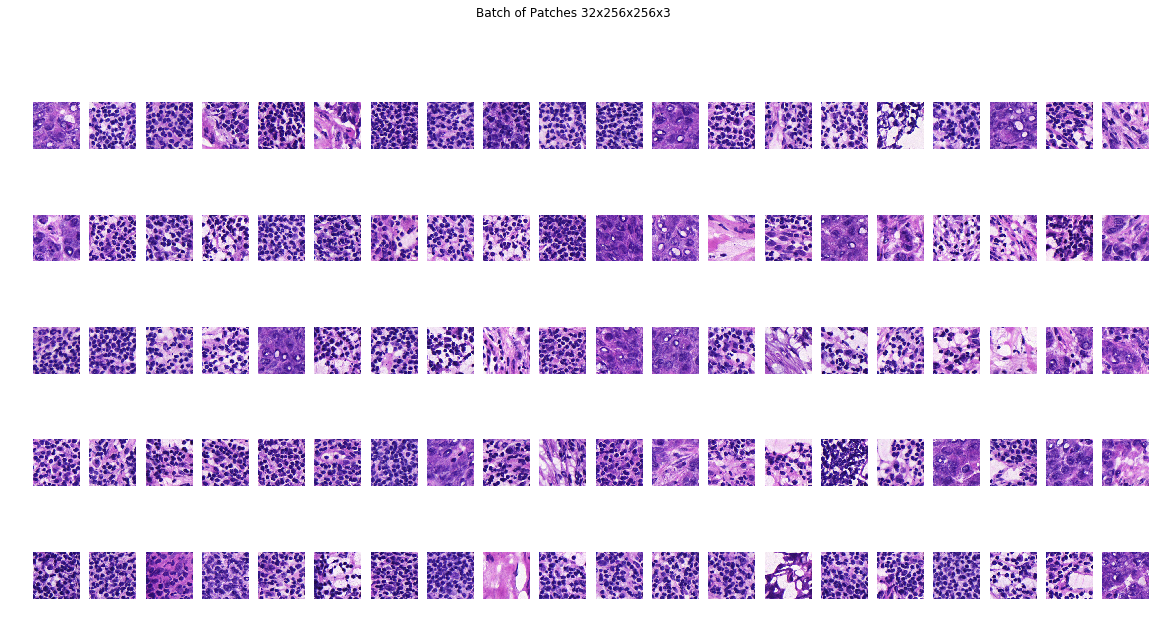

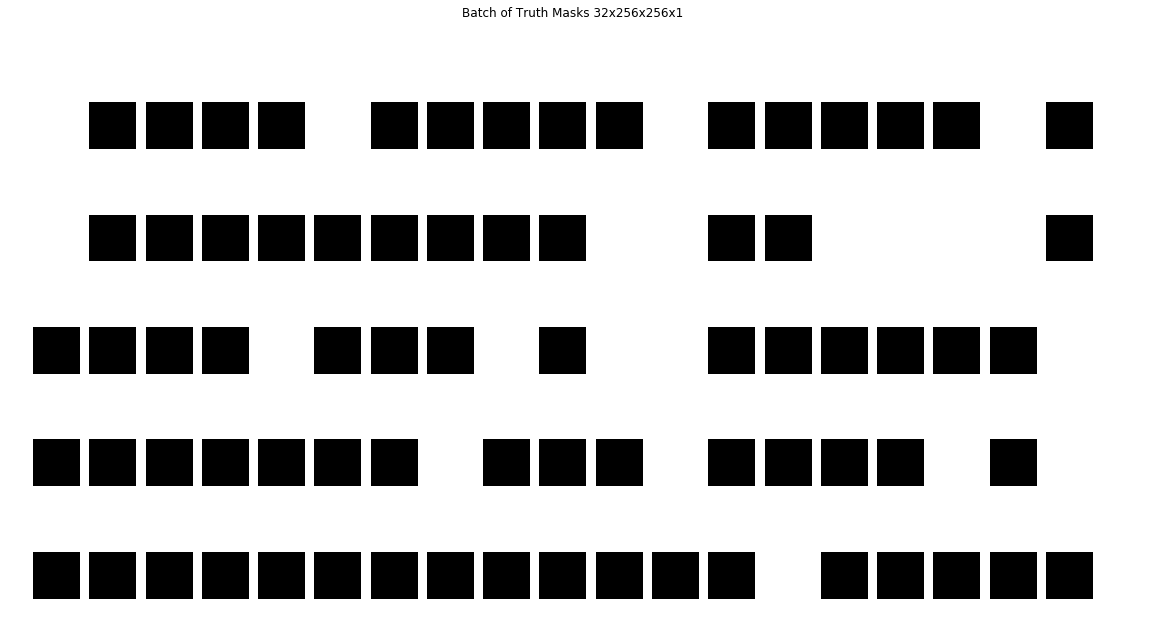

In [234]:
f, axes = plt.subplots(5,20, figsize=(20, 10));
ax = axes.flatten()
for i in range(0, example_X.shape[0]):
    _ = ax[i].imshow(example_X[i]);
    _ = ax[i].axis('off');
f.suptitle('Batch of Patches 32x256x256x3');
    
f, axes = plt.subplots(5, 20, figsize=(20, 10));
ax = axes.flatten()    
for i in range(0, example_X.shape[0]):
    _ = ax[i].imshow(example_y[i].argmax(axis=2), cmap='gray', vmin=0, vmax=1);
    _ = ax[i].axis('off');
f.suptitle('Batch of Truth Masks 32x256x256x1');

- mask 된 부분 약간 이상했음
- mask 가 확실히 흰색인 부분만 학습세트로 써야겠다고 결정
- 혹은 그 mask를 조절해서 원본과 맞춰야함 - 그러기 위해서, deepzoom, read_region, get_thumbnail 다시 다 확인해야함

## 위의 문제 사항 해결완료  

- slide properties 이용해서 min offset 구하기
- get.thumbnail에 소수 이용 가능
- OpenslideTest.ipynb 파일에서 확인할 수 있음

# 1-5. Data Augmentation

---
(camelyon17)
- convert images to horizontal flip
- convert images to vertical flip
- convert images to gray scale randomly (percentage = 10%)
- convert images brightness, contrast, saturation, hue slightly

---
(camelyon16 -google)
- 4 multiples of 90˚ rotations. + left-right flip (8 orientations)
- perturb color : (maximum delta)
  - brighteness 64/255,
  - saturation 0.25,
  - hue 0.04
  - contrast 0.75 
- Jitter : up to 8 pixels.
(- pixel values clipped [0,1], and scaled [-1,1])
---

# 1-6. Sampling

---
(google)
- 먼저 'normal'과 'tumor'를 같은 확률로 뽑고
- 그 라벨의 패치들을 가지고 있는 슬라이드를 랜덤하게 뽑고 (훈련중에 나타나는 패치수들을 한정적으로 만들지 않기 위해) 
- 그 슬라이드들에서 패치들을 샘플링한다.
---
(구현)
- 샘플링 전 데이터 분포 확인 필요
- min slide 몇개 뽑았을 때 원하는 sample size 나오는지 계산
- 


# 2. NetWork

In [ ]:
- U net 구조(지금) #base network도 하나 만들고
- Inception V3 (parameter 수 적은 걸로)
- ResNet

In [235]:
# cpu
model = Sequential()
model.add(Lambda(lambda x: x / 255.0 - 0.5, input_shape=(256, 256, 3)))
model.add(Convolution2D(100, (3, 3), strides=(2, 2), activation='elu', padding='same'))
model.add(MaxPooling2D())
model.add(Convolution2D(200, (3, 3), strides=(2, 2), activation='elu', padding='same'))
model.add(MaxPooling2D())
model.add(Convolution2D(300, (3, 3), activation='elu', padding='same'))
model.add(Convolution2D(300, (3, 3), activation='elu',  padding='same'))
model.add(Dropout(0.2))
model.add(Convolution2D(2, (1, 1))) # this is called upscore layer for some reason?
model.add(Conv2DTranspose(2, (31, 31), strides=(16, 16), activation='softmax', padding='same'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [236]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 100)     2800      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 100)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 200)       180200    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 200)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 300)       540300    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 300)       810300    
__________

# 3. Train

In [290]:
BATCH_SIZE = 50
N_EPOCHS = 10

NUM_SAMPLES = 10000

In [291]:
samples = find_patches_from_slide(slide_path)
samples = samples.sample(NUM_SAMPLES, random_state=42)
samples.reset_index(drop=True, inplace=True)

In [292]:
samples.is_tumor.value_counts()

False    7105
True     2895
Name: is_tumor, dtype: int64

In [293]:
len(samples)

10000

In [298]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42)
for train_index, test_index in split.split(samples, samples["is_tumor"]):
        train_samples = samples.loc[train_index]
        validation_samples = samples.loc[test_index]

In [299]:
N_EPOCHS

10

In [300]:
## TODO Add checkpoint mechanism to save old model before generating new

train_generator = gen_imgs(train_samples, BATCH_SIZE)
validation_generator = gen_imgs(validation_samples, BATCH_SIZE)

# Train model
train_start_time = datetime.now()
history = model.fit_generator(train_generator, np.ceil(len(train_samples) / BATCH_SIZE),
    validation_data=validation_generator,
    validation_steps=np.ceil(len(validation_samples) / BATCH_SIZE),
    epochs=N_EPOCHS)
train_end_time = datetime.now()
print("Model training time: %.1f minutes" % ((train_end_time - train_start_time).seconds / 60,))

Epoch 1/10
x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)
x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)
  1/180 [..............................] - ETA: 1:39:34 - loss: 0.3193 - acc: 0.8734x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)
x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)
  2/180 [..............................] - ETA: 1:39:23 - loss: 0.3407 - acc: 0.8544x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)
x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)
  3/180 [..............................] - ETA: 1:38:21 - loss: 0.3099 - acc: 0.8690x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)
x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)
  4/180 [..............................] - ETA: 1:37:34 - loss: 0.3335 - acc: 0.8632x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)
x_train_shape : (50, 256, 256, 3

 49/180 [=======>......................] - ETA: 1:09:53 - loss: 0.2706 - acc: 0.8904x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)
 50/180 [=======>......................] - ETA: 1:09:19 - loss: 0.2711 - acc: 0.8903x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)
 51/180 [=======>......................] - ETA: 1:08:50 - loss: 0.2700 - acc: 0.8906x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)
 52/180 [=======>......................] - ETA: 1:08:18 - loss: 0.2727 - acc: 0.8893x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)
 53/180 [=======>......................] - ETA: 1:07:50 - loss: 0.2728 - acc: 0.8892x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)
 54/180 [========>.....................] - ETA: 1:07:18 - loss: 0.2713 - acc: 0.8897x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)
 55/180 [========>.....................] - ETA: 1:06:47 - loss: 0.2712 - acc: 0.89

y_train_shape :  (50, 256, 256, 2)
103/180 [================>.............] - ETA: 40:44 - loss: 0.2759 - acc: 0.8858x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)
104/180 [================>.............] - ETA: 40:12 - loss: 0.2751 - acc: 0.8862x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)
105/180 [================>.............] - ETA: 39:40 - loss: 0.2750 - acc: 0.8863x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)
106/180 [================>.............] - ETA: 39:08 - loss: 0.2753 - acc: 0.8861x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)
107/180 [================>.............] - ETA: 38:36 - loss: 0.2756 - acc: 0.8860x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)
108/180 [=================>............] - ETA: 38:04 - loss: 0.2758 - acc: 0.8859x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)
109/180 [=================>............] - ETA: 37:32 - los

157/180 [=========================>....] - ETA: 12:06 - loss: 0.2735 - acc: 0.8861x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)
158/180 [=========================>....] - ETA: 11:35 - loss: 0.2730 - acc: 0.8864x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)
159/180 [=========================>....] - ETA: 11:03 - loss: 0.2727 - acc: 0.8865x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)
160/180 [=========================>....] - ETA: 10:32 - loss: 0.2727 - acc: 0.8865x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)
161/180 [=========================>....] - ETA: 10:00 - loss: 0.2726 - acc: 0.8865x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)
162/180 [==========================>...] - ETA: 9:28 - loss: 0.2730 - acc: 0.8864 x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)
163/180 [==========================>...] - ETA: 8:57 - loss: 0.2729 - acc: 0.8863x_train_shape

 24/180 [===>..........................] - ETA: 53:17 - loss: 0.2606 - acc: 0.8958x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)
 25/180 [===>..........................] - ETA: 54:03 - loss: 0.2578 - acc: 0.8973x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)
 26/180 [===>..........................] - ETA: 54:43 - loss: 0.2576 - acc: 0.8963x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)
 27/180 [===>..........................] - ETA: 55:18 - loss: 0.2561 - acc: 0.8962x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)
 28/180 [===>..........................] - ETA: 55:48 - loss: 0.2558 - acc: 0.8964x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)
 29/180 [===>..........................] - ETA: 56:14 - loss: 0.2551 - acc: 0.8967x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)
 30/180 [====>.........................] - ETA: 56:36 - loss: 0.2541 - acc: 0.8972x_train_shap

 78/180 [============>.................] - ETA: 47:30 - loss: 0.2396 - acc: 0.9033x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)
 79/180 [============>.................] - ETA: 47:06 - loss: 0.2395 - acc: 0.9036x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)
 80/180 [============>.................] - ETA: 46:43 - loss: 0.2391 - acc: 0.9039x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)
 81/180 [============>.................] - ETA: 46:19 - loss: 0.2396 - acc: 0.9037x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)
 82/180 [============>.................] - ETA: 45:54 - loss: 0.2388 - acc: 0.9045x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)
 83/180 [============>.................] - ETA: 45:30 - loss: 0.2394 - acc: 0.9042x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)
 84/180 [=============>................] - ETA: 45:05 - loss: 0.2398 - acc: 0.9039x_train_shap

132/180 [=====================>........] - ETA: 23:26 - loss: 0.2384 - acc: 0.9038x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)
133/180 [=====================>........] - ETA: 22:57 - loss: 0.2383 - acc: 0.9038x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)
134/180 [=====================>........] - ETA: 22:29 - loss: 0.2379 - acc: 0.9041x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)
135/180 [=====================>........] - ETA: 22:00 - loss: 0.2377 - acc: 0.9040x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)
136/180 [=====================>........] - ETA: 21:31 - loss: 0.2377 - acc: 0.9041x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)
137/180 [=====================>........] - ETA: 21:03 - loss: 0.2384 - acc: 0.9040x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)
138/180 [======================>.......] - ETA: 20:34 - loss: 0.2380 - acc: 0.9041x_train_shap

y_train_shape :  (50, 256, 256, 2)
x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)
x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)
x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)
x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)
180/180 [==============================] - 5668s 31s/step - loss: 0.2371 - acc: 0.9037 - val_loss: 0.2257 - val_acc: 0.9091
Epoch 3/10
  9/180 [>.............................] - ETA: 33s - loss: 0.3844 - acc: 0.84 - ETA: 33s - loss: 0.3371 - acc: 0.86 - ETA: 35s - loss: 0.3027 - acc: 0.88 - ETA: 34s - loss: 0.2839 - acc: 0.89 - ETA: 33s - loss: 0.2633 - acc: 0.90 - ETA: 33s - loss: 0.2690 - acc: 0.89 - ETA: 33s - loss: 0.2591 - acc: 0.90 - ETA: 32s - loss: 0.2542 - acc: 0.90 - ETA: 32s - loss: 0.2692 - acc: 0.8891x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)
 10/180 [>.............................] - ETA: 9:24 - loss: 0.2544 - acc: 0.8969x_train_shape : (50,

 53/180 [=======>......................] - ETA: 55:51 - loss: 0.2153 - acc: 0.9101x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)
 54/180 [========>.....................] - ETA: 55:36 - loss: 0.2138 - acc: 0.9106x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)
 55/180 [========>.....................] - ETA: 55:21 - loss: 0.2122 - acc: 0.9113x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)
 56/180 [========>.....................] - ETA: 55:05 - loss: 0.2142 - acc: 0.9113x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)
 57/180 [========>.....................] - ETA: 54:49 - loss: 0.2163 - acc: 0.9101x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)
 58/180 [========>.....................] - ETA: 54:31 - loss: 0.2151 - acc: 0.9106x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)
 59/180 [========>.....................] - ETA: 54:14 - loss: 0.2152 - acc: 0.9104x_train_shap

107/180 [================>.............] - ETA: 35:10 - loss: 0.2147 - acc: 0.9123x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)
108/180 [=================>............] - ETA: 34:42 - loss: 0.2152 - acc: 0.9124x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)
109/180 [=================>............] - ETA: 34:15 - loss: 0.2150 - acc: 0.9125x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)
110/180 [=================>............] - ETA: 33:48 - loss: 0.2143 - acc: 0.9127x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)
111/180 [=================>............] - ETA: 33:20 - loss: 0.2138 - acc: 0.9129x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)
112/180 [=================>............] - ETA: 32:53 - loss: 0.2145 - acc: 0.9126x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)
113/180 [=================>............] - ETA: 32:25 - loss: 0.2147 - acc: 0.9125x_train_shap

161/180 [=========================>....] - ETA: 9:25 - loss: 0.2199 - acc: 0.9105x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)
162/180 [==========================>...] - ETA: 8:55 - loss: 0.2200 - acc: 0.9106x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)
163/180 [==========================>...] - ETA: 8:26 - loss: 0.2198 - acc: 0.9106x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)
164/180 [==========================>...] - ETA: 7:56 - loss: 0.2196 - acc: 0.9107x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)
165/180 [==========================>...] - ETA: 7:26 - loss: 0.2191 - acc: 0.9110x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)
166/180 [==========================>...] - ETA: 6:57 - loss: 0.2191 - acc: 0.9109x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)
167/180 [==========================>...] - ETA: 6:27 - loss: 0.2187 - acc: 0.9111x_train_shape : (50

 28/180 [===>..........................] - ETA: 55:51 - loss: 0.2028 - acc: 0.9221x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)
 29/180 [===>..........................] - ETA: 56:16 - loss: 0.2045 - acc: 0.9209x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)
 30/180 [====>.........................] - ETA: 56:38 - loss: 0.2059 - acc: 0.9196x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)
 31/180 [====>.........................] - ETA: 56:57 - loss: 0.2062 - acc: 0.9195x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)
 32/180 [====>.........................] - ETA: 57:12 - loss: 0.2052 - acc: 0.9203x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)
 33/180 [====>.........................] - ETA: 57:25 - loss: 0.2061 - acc: 0.9202x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)
 34/180 [====>.........................] - ETA: 57:35 - loss: 0.2082 - acc: 0.9195x_train_shap

 82/180 [============>.................] - ETA: 45:54 - loss: 0.2156 - acc: 0.9139x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)
 83/180 [============>.................] - ETA: 45:29 - loss: 0.2160 - acc: 0.9137x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)
 84/180 [=============>................] - ETA: 45:05 - loss: 0.2162 - acc: 0.9135x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)
 85/180 [=============>................] - ETA: 44:40 - loss: 0.2151 - acc: 0.9140x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)
 86/180 [=============>................] - ETA: 44:15 - loss: 0.2156 - acc: 0.9135x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)
 87/180 [=============>................] - ETA: 43:50 - loss: 0.2188 - acc: 0.9120x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)
 88/180 [=============>................] - ETA: 43:25 - loss: 0.2189 - acc: 0.9119x_train_shap

136/180 [=====================>........] - ETA: 21:31 - loss: 0.2239 - acc: 0.9090x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)
137/180 [=====================>........] - ETA: 21:02 - loss: 0.2239 - acc: 0.9090x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)
138/180 [======================>.......] - ETA: 20:33 - loss: 0.2243 - acc: 0.9090x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)
139/180 [======================>.......] - ETA: 20:04 - loss: 0.2247 - acc: 0.9089x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)
140/180 [======================>.......] - ETA: 19:35 - loss: 0.2243 - acc: 0.9090x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)
141/180 [======================>.......] - ETA: 19:07 - loss: 0.2237 - acc: 0.9092x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)
142/180 [======================>.......] - ETA: 18:38 - loss: 0.2234 - acc: 0.9093x_train_shap

  9/180 [>.............................] - ETA: 35s - loss: 0.1957 - acc: 0.93 - ETA: 34s - loss: 0.2316 - acc: 0.90 - ETA: 33s - loss: 0.2417 - acc: 0.90 - ETA: 34s - loss: 0.2540 - acc: 0.89 - ETA: 34s - loss: 0.2421 - acc: 0.90 - ETA: 33s - loss: 0.2356 - acc: 0.90 - ETA: 33s - loss: 0.2250 - acc: 0.90 - ETA: 32s - loss: 0.2128 - acc: 0.91 - ETA: 32s - loss: 0.2269 - acc: 0.9119x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)
 10/180 [>.............................] - ETA: 9:18 - loss: 0.2292 - acc: 0.9099x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)
x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)
 11/180 [>.............................] - ETA: 17:08 - loss: 0.2308 - acc: 0.9088x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)
x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)
 12/180 [=>............................] - ETA: 23:35 - loss: 0.2270 - acc: 0.9103x_train_shape : (50, 256, 

 56/180 [========>.....................] - ETA: 55:20 - loss: 0.2134 - acc: 0.9163x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)
 57/180 [========>.....................] - ETA: 55:02 - loss: 0.2132 - acc: 0.9164x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)
 58/180 [========>.....................] - ETA: 54:45 - loss: 0.2146 - acc: 0.9160x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)
 59/180 [========>.....................] - ETA: 54:26 - loss: 0.2138 - acc: 0.9162x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)
 60/180 [=========>....................] - ETA: 54:08 - loss: 0.2141 - acc: 0.9159x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)
 61/180 [=========>....................] - ETA: 53:49 - loss: 0.2139 - acc: 0.9158x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)
 62/180 [=========>....................] - ETA: 53:30 - loss: 0.2133 - acc: 0.9158x_train_shap

110/180 [=================>............] - ETA: 33:47 - loss: 0.2035 - acc: 0.9186x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)
111/180 [=================>............] - ETA: 33:20 - loss: 0.2026 - acc: 0.9190x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)
112/180 [=================>............] - ETA: 32:52 - loss: 0.2025 - acc: 0.9190x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)
113/180 [=================>............] - ETA: 32:24 - loss: 0.2016 - acc: 0.9193x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)
114/180 [==================>...........] - ETA: 31:57 - loss: 0.2022 - acc: 0.9192x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)
115/180 [==================>...........] - ETA: 31:29 - loss: 0.2020 - acc: 0.9195x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)
116/180 [==================>...........] - ETA: 31:01 - loss: 0.2021 - acc: 0.9193x_train_shap

164/180 [==========================>...] - ETA: 7:56 - loss: 0.2034 - acc: 0.9178x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)
165/180 [==========================>...] - ETA: 7:27 - loss: 0.2032 - acc: 0.9179x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)
166/180 [==========================>...] - ETA: 6:57 - loss: 0.2030 - acc: 0.9180x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)
167/180 [==========================>...] - ETA: 6:27 - loss: 0.2030 - acc: 0.9179x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)
168/180 [===========================>..] - ETA: 5:58 - loss: 0.2028 - acc: 0.9180x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)
169/180 [===========================>..] - ETA: 5:28 - loss: 0.2028 - acc: 0.9180x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)
170/180 [===========================>..] - ETA: 4:58 - loss: 0.2029 - acc: 0.9178x_train_shape : (50

 31/180 [====>.........................] - ETA: 57:21 - loss: 0.1969 - acc: 0.9235x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)
 32/180 [====>.........................] - ETA: 57:47 - loss: 0.1959 - acc: 0.9235x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)
 33/180 [====>.........................] - ETA: 58:07 - loss: 0.1967 - acc: 0.9229x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)
 34/180 [====>.........................] - ETA: 58:22 - loss: 0.1958 - acc: 0.9234x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)
 35/180 [====>.........................] - ETA: 58:33 - loss: 0.1964 - acc: 0.9228x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)
 36/180 [=====>........................] - ETA: 58:39 - loss: 0.1949 - acc: 0.9233x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)
 37/180 [=====>........................] - ETA: 58:41 - loss: 0.1953 - acc: 0.9232x_train_shap

 85/180 [=============>................] - ETA: 44:51 - loss: 0.1969 - acc: 0.9220x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)
 86/180 [=============>................] - ETA: 44:25 - loss: 0.1973 - acc: 0.9219x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)
 87/180 [=============>................] - ETA: 44:00 - loss: 0.1970 - acc: 0.9220x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)
 88/180 [=============>................] - ETA: 43:35 - loss: 0.1963 - acc: 0.9224x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)
 89/180 [=============>................] - ETA: 43:09 - loss: 0.1969 - acc: 0.9221x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)
 90/180 [==============>...............] - ETA: 42:43 - loss: 0.1971 - acc: 0.9221x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)
 91/180 [==============>...............] - ETA: 42:17 - loss: 0.1974 - acc: 0.9219x_train_shap

139/180 [======================>.......] - ETA: 20:06 - loss: 0.1881 - acc: 0.9243x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)
140/180 [======================>.......] - ETA: 19:37 - loss: 0.1878 - acc: 0.9244x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)
141/180 [======================>.......] - ETA: 19:09 - loss: 0.1876 - acc: 0.9245x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)
142/180 [======================>.......] - ETA: 18:40 - loss: 0.1876 - acc: 0.9246x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)
143/180 [======================>.......] - ETA: 18:10 - loss: 0.1878 - acc: 0.9245x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)
144/180 [=======================>......] - ETA: 17:41 - loss: 0.1878 - acc: 0.9245x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)
145/180 [=======================>......] - ETA: 17:12 - loss: 0.1875 - acc: 0.9246x_train_shap

y_train_shape :  (50, 256, 256, 2)
 11/180 [>.............................] - ETA: 17:00 - loss: 0.1938 - acc: 0.9221x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)
x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)
 12/180 [=>............................] - ETA: 23:15 - loss: 0.1919 - acc: 0.9237x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)
x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)
 13/180 [=>............................] - ETA: 28:28 - loss: 0.1940 - acc: 0.9238x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)
x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)
 14/180 [=>............................] - ETA: 32:53 - loss: 0.1960 - acc: 0.9234x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)
x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)
 15/180 [=>............................] - ETA: 36:36 - loss: 0.1974 - acc: 0.9221x_t

 60/180 [=========>....................] - ETA: 53:47 - loss: 0.1883 - acc: 0.9253x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)
 61/180 [=========>....................] - ETA: 53:29 - loss: 0.1876 - acc: 0.9256x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)
 62/180 [=========>....................] - ETA: 53:10 - loss: 0.1872 - acc: 0.9256x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)
 63/180 [=========>....................] - ETA: 52:50 - loss: 0.1898 - acc: 0.9243x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)
 64/180 [=========>....................] - ETA: 52:31 - loss: 0.1895 - acc: 0.9245x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)
 65/180 [=========>....................] - ETA: 52:11 - loss: 0.1888 - acc: 0.9248x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)
 66/180 [==========>...................] - ETA: 51:50 - loss: 0.1908 - acc: 0.9245x_train_shap

114/180 [==================>...........] - ETA: 31:49 - loss: 0.1981 - acc: 0.9217x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)
115/180 [==================>...........] - ETA: 31:21 - loss: 0.1978 - acc: 0.9220x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)
116/180 [==================>...........] - ETA: 30:54 - loss: 0.1980 - acc: 0.9218x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)
117/180 [==================>...........] - ETA: 30:26 - loss: 0.1977 - acc: 0.9219x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)
118/180 [==================>...........] - ETA: 29:58 - loss: 0.1979 - acc: 0.9219x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)
119/180 [==================>...........] - ETA: 29:30 - loss: 0.1976 - acc: 0.9220x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)
120/180 [===================>..........] - ETA: 29:02 - loss: 0.1975 - acc: 0.9221x_train_shap

168/180 [===========================>..] - ETA: 5:55 - loss: 0.1933 - acc: 0.9230x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)
169/180 [===========================>..] - ETA: 5:26 - loss: 0.1943 - acc: 0.9225x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)
170/180 [===========================>..] - ETA: 4:56 - loss: 0.1948 - acc: 0.9223x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)
171/180 [===========================>..] - ETA: 4:27 - loss: 0.1950 - acc: 0.9222x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)
172/180 [===========================>..] - ETA: 3:57 - loss: 0.1951 - acc: 0.9222x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)
173/180 [===========================>..] - ETA: 3:27 - loss: 0.1949 - acc: 0.9222x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)
174/180 [============================>.] - ETA: 2:58 - loss: 0.1950 - acc: 0.9222x_train_shape : (50

 35/180 [====>.........................] - ETA: 57:32 - loss: 0.1729 - acc: 0.9319x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)
 36/180 [=====>........................] - ETA: 57:38 - loss: 0.1720 - acc: 0.9321x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)
 37/180 [=====>........................] - ETA: 57:42 - loss: 0.1722 - acc: 0.9318x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)
 38/180 [=====>........................] - ETA: 57:44 - loss: 0.1727 - acc: 0.9311x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)
 39/180 [=====>........................] - ETA: 57:44 - loss: 0.1715 - acc: 0.9317x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)
 40/180 [=====>........................] - ETA: 57:42 - loss: 0.1703 - acc: 0.9322x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)
 41/180 [=====>........................] - ETA: 57:39 - loss: 0.1719 - acc: 0.9314x_train_shap

 89/180 [=============>................] - ETA: 42:54 - loss: 0.1765 - acc: 0.9293x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)
 90/180 [==============>...............] - ETA: 42:29 - loss: 0.1759 - acc: 0.9295x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)
 91/180 [==============>...............] - ETA: 42:03 - loss: 0.1756 - acc: 0.9295x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)
 92/180 [==============>...............] - ETA: 41:38 - loss: 0.1742 - acc: 0.9301x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)
 93/180 [==============>...............] - ETA: 41:12 - loss: 0.1733 - acc: 0.9306x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)
 94/180 [==============>...............] - ETA: 40:46 - loss: 0.1731 - acc: 0.9306x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)
 95/180 [==============>...............] - ETA: 40:20 - loss: 0.1746 - acc: 0.9302x_train_shap

143/180 [======================>.......] - ETA: 57:23 - loss: 0.1789 - acc: 0.9289x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)
144/180 [=======================>......] - ETA: 55:35 - loss: 0.1793 - acc: 0.9288x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)
145/180 [=======================>......] - ETA: 53:47 - loss: 0.1790 - acc: 0.9292x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)
146/180 [=======================>......] - ETA: 52:01 - loss: 0.1791 - acc: 0.9291x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)
147/180 [=======================>......] - ETA: 50:15 - loss: 0.1795 - acc: 0.9288x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)
148/180 [=======================>......] - ETA: 48:31 - loss: 0.1798 - acc: 0.9287x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)
149/180 [=======================>......] - ETA: 46:48 - loss: 0.1800 - acc: 0.9288x_train_shap

y_train_shape :  (50, 256, 256, 2)
x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)
 14/180 [=>............................] - ETA: 33:56 - loss: 0.1626 - acc: 0.9343x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)
x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)
 15/180 [=>............................] - ETA: 37:54 - loss: 0.1637 - acc: 0.9344x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)
x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)
 16/180 [=>............................] - ETA: 41:21 - loss: 0.1626 - acc: 0.9346x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)
x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)
 17/180 [=>............................] - ETA: 44:12 - loss: 0.1639 - acc: 0.9332x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)
x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)
 18/180 [==>....

 64/180 [=========>....................] - ETA: 54:37 - loss: 0.1810 - acc: 0.9270x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)
 65/180 [=========>....................] - ETA: 54:14 - loss: 0.1795 - acc: 0.9278x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)
 66/180 [==========>...................] - ETA: 53:51 - loss: 0.1792 - acc: 0.9278x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)
 67/180 [==========>...................] - ETA: 53:27 - loss: 0.1789 - acc: 0.9278x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)
 68/180 [==========>...................] - ETA: 53:04 - loss: 0.1784 - acc: 0.9282x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)
 69/180 [==========>...................] - ETA: 52:40 - loss: 0.1779 - acc: 0.9283x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)
 70/180 [==========>...................] - ETA: 52:16 - loss: 0.1776 - acc: 0.9284x_train_shap

118/180 [==================>...........] - ETA: 30:36 - loss: 0.1822 - acc: 0.9272x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)
119/180 [==================>...........] - ETA: 30:07 - loss: 0.1819 - acc: 0.9273x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)
120/180 [===================>..........] - ETA: 29:38 - loss: 0.1814 - acc: 0.9274x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)
121/180 [===================>..........] - ETA: 29:09 - loss: 0.1808 - acc: 0.9277x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)
122/180 [===================>..........] - ETA: 28:40 - loss: 0.1814 - acc: 0.9275x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)
123/180 [===================>..........] - ETA: 28:11 - loss: 0.1818 - acc: 0.9273x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)
124/180 [===================>..........] - ETA: 27:42 - loss: 0.1813 - acc: 0.9276x_train_shap

172/180 [===========================>..] - ETA: 4:00 - loss: 0.1805 - acc: 0.9281x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)
173/180 [===========================>..] - ETA: 3:30 - loss: 0.1804 - acc: 0.9282x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)
174/180 [============================>.] - ETA: 3:00 - loss: 0.1804 - acc: 0.9281x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)
175/180 [============================>.] - ETA: 2:30 - loss: 0.1803 - acc: 0.9282x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)
176/180 [============================>.] - ETA: 2:00 - loss: 0.1802 - acc: 0.9282x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)
177/180 [============================>.] - ETA: 1:30 - loss: 0.1804 - acc: 0.9281x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)
178/180 [============================>.] - ETA: 1:00 - loss: 0.1807 - acc: 0.9281x_train_shape : (50

 39/180 [=====>........................] - ETA: 57:51 - loss: 0.1651 - acc: 0.9366x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)
 40/180 [=====>........................] - ETA: 57:49 - loss: 0.1653 - acc: 0.9364x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)
 41/180 [=====>........................] - ETA: 57:46 - loss: 0.1645 - acc: 0.9369x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)
 42/180 [======>.......................] - ETA: 57:42 - loss: 0.1632 - acc: 0.9373x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)
 43/180 [======>.......................] - ETA: 57:37 - loss: 0.1623 - acc: 0.9377x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)
 44/180 [======>.......................] - ETA: 57:30 - loss: 0.1615 - acc: 0.9382x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)
 45/180 [======>.......................] - ETA: 57:22 - loss: 0.1625 - acc: 0.9378x_train_shap

 93/180 [==============>...............] - ETA: 41:16 - loss: 0.1779 - acc: 0.9311x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)
 94/180 [==============>...............] - ETA: 40:50 - loss: 0.1776 - acc: 0.9311x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)
 95/180 [==============>...............] - ETA: 40:24 - loss: 0.1774 - acc: 0.9312x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)
 96/180 [===============>..............] - ETA: 39:58 - loss: 0.1780 - acc: 0.9306x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)
 97/180 [===============>..............] - ETA: 39:31 - loss: 0.1798 - acc: 0.9301x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)
 98/180 [===============>..............] - ETA: 39:05 - loss: 0.1801 - acc: 0.9297x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)
 99/180 [===============>..............] - ETA: 38:39 - loss: 0.1797 - acc: 0.9298x_train_shap

147/180 [=======================>......] - ETA: 16:14 - loss: 0.1769 - acc: 0.9306x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)
148/180 [=======================>......] - ETA: 15:45 - loss: 0.1766 - acc: 0.9308x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)
149/180 [=======================>......] - ETA: 15:16 - loss: 0.1764 - acc: 0.9308x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)
150/180 [========================>.....] - ETA: 14:46 - loss: 0.1767 - acc: 0.9308x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)
151/180 [========================>.....] - ETA: 14:17 - loss: 0.1764 - acc: 0.9309x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)
152/180 [========================>.....] - ETA: 13:48 - loss: 0.1772 - acc: 0.9306x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)
153/180 [========================>.....] - ETA: 13:19 - loss: 0.1781 - acc: 0.9303x_train_shap

In [301]:
# Save model
model.save('model0121_2.h5')

In [ ]:
# 시각화 해보기

# 4. Evaluate

In [307]:
# 4-1. Visualization A single patches prediction

In [308]:
def predict_from_model(patch, model):
    """Predict which pixels are tumor.
    
    input: patch: 256x256x3, rgb image
    input: model: keras model
    output: prediction: 256x256x1, per-pixel tumor probability
    """
    
    prediction = model.predict(patch.reshape(1, 256, 256, 3))
    prediction = prediction[:, :, :, 1].reshape(256, 256)
    return prediction

def plot_blend(patch, prediction, ax, alpha=0.75):
    """alpha blend patch and prediction.
    https://matplotlib.org/examples/pylab_examples/layer_images.html
    
    input: patch: 256x256x3, rgb image
    input: prediction: 256x256x1, per-pixel tumor probability
    input: ax: maplotlib Axes object
    input: alpha: alpha blend
    """
    
    dx, dy = 0.05, 0.05
    x = np.arange(0, patch.shape[1] - 1, dx)
    y = np.arange(0, patch.shape[0] - 1, dy)
    xmin, xmax, ymin, ymax = np.amin(x), np.amax(x), np.amin(y), np.amax(y)
    extent = xmin, xmax, ymin, ymax

    # fig = plt.figure(frameon=False, figsize=(10, 5))
    Z1 = cv2.cvtColor(patch, code=cv2.COLOR_RGB2GRAY)
    Z2 = prediction

    im1 = ax.imshow(Z1, cmap='gray', extent=extent)
    im2 = ax.imshow(Z2, cmap='jet', alpha=alpha, vmin=0.0, vmax=1.0,
                     extent=extent)
    ax.axis('off');

def plot_patch_with_pred(patch, truth, prediction, title_str='', alpha=0.6):
    """
    input: patch: 256x256x3, rgb image
    input: truth: 256x256x2, onehot output classes (not_tumor, tumor)
    input: prediction: 256x256x1, per-pixel tumor probability
    """
    gs = gridspec.GridSpec(2, 4, width_ratios=[10, 10, 19, 1])
    ax0 = plt.subplot(gs[0, 0])
    ax1 = plt.subplot(gs[0, 1])
    ax2 = plt.subplot(gs[1, 0])
    ax3 = plt.subplot(gs[1, 1])
    ax4 = plt.subplot(gs[:, 2])
    axc = plt.subplot(gs[:, 3])

    ax0.imshow(patch);
    ax0.set_title('Original')
    
    ax1.imshow(truth.argmax(axis=2), cmap='gray', vmin=0, vmax=1);
    ax1.set_title('Truth mask (white=tumor, black=not_tumor)')
    
    p = ax2.imshow(prediction, cmap='jet', vmin=0, vmax=1);
    ax2.set_title('Prediction heatmap')

    ax3.imshow((prediction > 0.5).astype(np.int), cmap='gray', vmin=0, vmax=1);
    ax3.set_title('Prediction mask (white=tumor, black=not_tumor)')
    
    plot_blend(patch, prediction, ax4, alpha)
    ax4.set_title('Original+Prediction blend')
    
    fig = plt.gcf()
    fig.set_size_inches(20, 10)
    fig.suptitle(title_str)
    fig.colorbar(p, cax=axc, orientation="vertical")
    axc.set_title('Probability pixel is tumor')

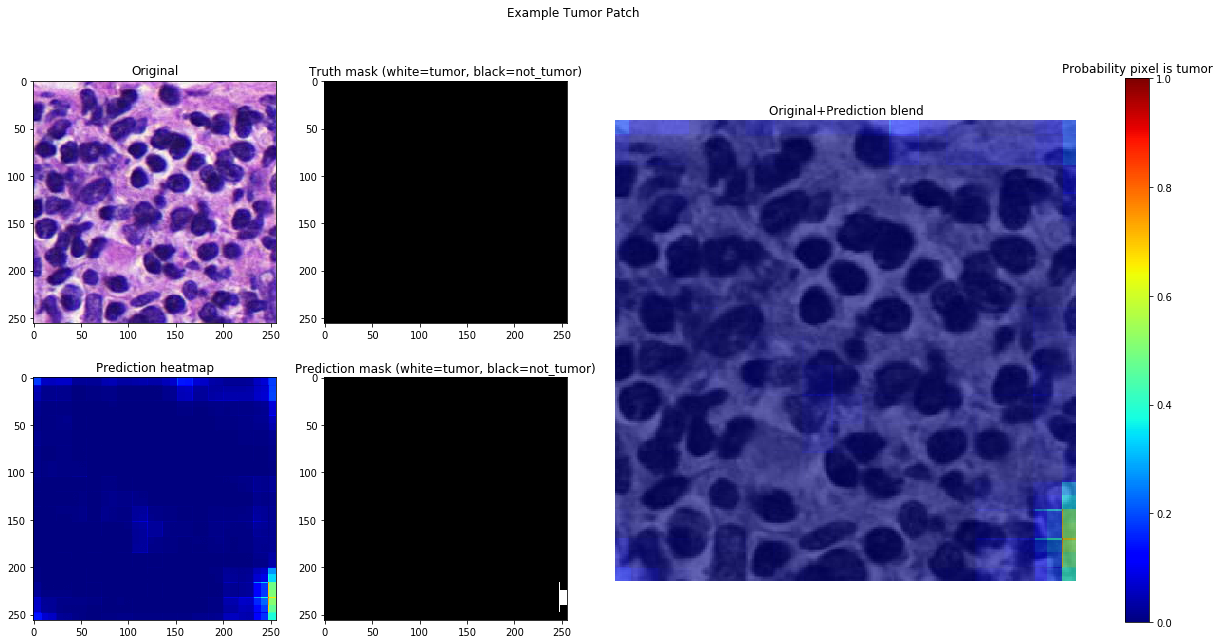

In [377]:
# 3 , 5(0.91) , 8(완전잘못) , 13(0.88) , 16(0.87) 32, 37
example_patch = example_X[49]
example_truth = example_y[49]

prediction = predict_from_model(example_patch, model)
plot_patch_with_pred(example_patch, example_truth, prediction, title_str='Example Tumor Patch')

count    65536.000000
mean         0.014234
std          0.044412
min          0.000082
25%          0.001217
50%          0.003346
75%          0.009651
max          0.823735
dtype: float64


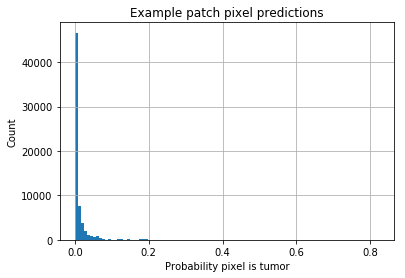

In [378]:
pred_s = pd.Series(prediction.flatten())
print(pred_s.describe())
ax = pred_s.hist(bins=100);
ax.set_title('Example patch pixel predictions');
ax.set_ylabel('Count');
ax.set_xlabel('Probability pixel is tumor');

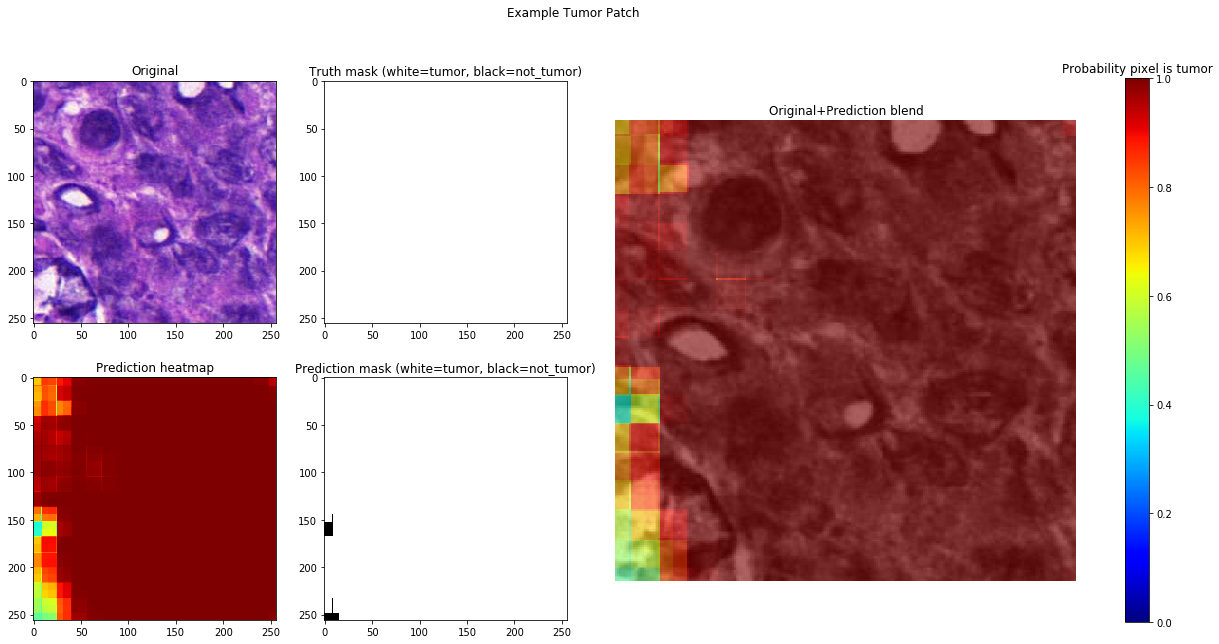

In [379]:
example_patch = example_X[50]
example_truth = example_y[50]

prediction = predict_from_model(example_patch, model)
plot_patch_with_pred(example_patch, example_truth, prediction, title_str='Example Tumor Patch')

count    65536.000000
mean         0.978082
std          0.075574
min          0.372123
25%          0.998963
50%          0.999985
75%          1.000000
max          1.000000
dtype: float64


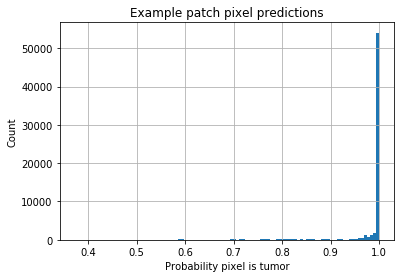

In [380]:
pred_s = pd.Series(prediction.flatten())
print(pred_s.describe())
ax = pred_s.hist(bins=100);
ax.set_title('Example patch pixel predictions');
ax.set_ylabel('Count');
ax.set_xlabel('Probability pixel is tumor');

In [ ]:
# 4-2. Performance Metrics

In [ ]:
# threshold = 0.9 로 바꿔보자

In [314]:
validation_generator = gen_imgs(validation_samples, BATCH_SIZE)
validation_steps = np.ceil(len(validation_samples) / BATCH_SIZE)

confusion_mtx = np.zeros((2, 2))

for i in tqdm(range(int(validation_steps))):
    X, y  = next(validation_generator)
    preds = predict_batch_from_model(X, model)
    
    y_true = y[:, :, :, 1].ravel()
    y_pred = np.uint8(preds > 0.9).ravel()
    
    confusion_mtx += confusion_matrix(y_true, y_pred, labels=[0, 1])

  0%|                                                                                           | 0/20 [00:00<?, ?it/s]


KeyboardInterrupt: 

In [304]:
confusion_mtx

array([[45355330.,  1240254.],
       [ 2827868., 16112548.]])

In [305]:
tn = confusion_mtx[0, 0]
fp = confusion_mtx[0, 1]
fn = confusion_mtx[1, 0]
tp = confusion_mtx[1, 1]

In [306]:
accuracy = (tp + tn) / (tp + tn + fp + fn)
recall = tp / (tp + fn)
precision = tp / (tp + fp)
f1_score = 2 * ((precision * recall) / (precision + recall))

print("Accuracy: %.2f" % accuracy)
print("Recall: %.2f" % recall)
print("Precision: %.2f" % precision)
print("F1 Score: %.2f" % f1_score)

Accuracy: 0.94
Recall: 0.85
Precision: 0.93
F1 Score: 0.89


# GPU 

- https://3months.tistory.com/206

In [313]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 15584561399726868908
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 2218013491
locality {
  bus_id: 1
  links {
  }
}
incarnation: 488385419233232722
physical_device_desc: "device: 0, name: GeForce GTX 1060 3GB, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


In [ ]:
import keras.backend.tensorflow_backend as K

In [ ]:
BATCH_SIZE = 50
N_EPOCHS = 10

NUM_SAMPLES = 10000

In [ ]:
with K.tf.device('/gpu:0'):
    # Network
    model = Sequential()
    model.add(Lambda(lambda x: x / 255.0 - 0.5, input_shape=(256, 256, 3)))
    model.add(Convolution2D(100, (3, 3), strides=(2, 2), activation='elu', padding='same'))
    model.add(MaxPooling2D())
    model.add(Convolution2D(200, (3, 3), strides=(2, 2), activation='elu', padding='same'))
    model.add(MaxPooling2D())
    model.add(Convolution2D(300, (3, 3), activation='elu', padding='same'))
    model.add(Convolution2D(300, (3, 3), activation='elu',  padding='same'))
    model.add(Dropout(0.2))
    model.add(Convolution2D(2, (1, 1))) # this is called upscore layer for some reason?
    model.add(Conv2DTranspose(2, (31, 31), strides=(16, 16), activation='softmax', padding='same'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    # Training
    samples = find_patches_from_slide(slide_path)
    samples = samples.sample(NUM_SAMPLES, random_state=42)
    samples.reset_index(drop=True, inplace=True)
    
    split = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42)
    for train_index, test_index in split.split(samples, samples["is_tumor"]):
            train_samples = samples.loc[train_index]
            validation_samples = samples.loc[test_index]
    train_generator = gen_imgs(train_samples, BATCH_SIZE)
    validation_generator = gen_imgs(validation_samples, BATCH_SIZE)

    # Train model
    train_start_time = datetime.now()
    history = model.fit_generator(train_generator, np.ceil(len(train_samples) / BATCH_SIZE),
        validation_data=validation_generator,
        validation_steps=np.ceil(len(validation_samples) / BATCH_SIZE),
        epochs=N_EPOCHS)
    train_end_time = datetime.now()
    print("Model training time: %.1f minutes" % ((train_end_time - train_start_time).seconds / 60,))
    

In [ ]:
with K.tf.device('/gpu:0'):
    validation_generator = gen_imgs(validation_samples, BATCH_SIZE)
    validation_steps = np.ceil(len(validation_samples) / BATCH_SIZE)

    confusion_mtx = np.zeros((2, 2))

    for i in tqdm(range(int(validation_steps))):
        X, y  = next(validation_generator)
        preds = predict_batch_from_model(X, model)

        y_true = y[:, :, :, 1].ravel()
        y_pred = np.uint8(preds > 0.5).ravel()

        confusion_mtx += confusion_matrix(y_true, y_pred, labels=[0, 1])